  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9b43e3074811bf21f55ea37c16aa13c9b84b41d3b6e0b85ff78d5b7e4d8f7a35
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
[INFO] Using device: cuda
[INFO] Loading dataset from: /kaggle/input/againunified/unified_conversation_dataset.csv
[INFO] Found 620 toxic conversations for T5 generation fine-tuning.
[INFO] Data split: 496 training samples, 62 validation samples, 62 test samples.
[INFO] Loading T5 model and tokenizer: t5-base


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

[INFO] T5 Datasets and DataCollator initialized. Model 't5-base' loaded on cuda.

[INFO] Starting T5 fine-tuning for Most Toxic Sentence Generation...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=Encoder

Epoch,Training Loss,Validation Loss
1,No log,0.271874
2,1.089800,0.203037
3,1.089800,0.168953
4,0.293200,0.161380
5,0.242400,0.153795
6,0.242400,0.149358
7,0.226200,0.148570


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separat

[INFO] T5 fine-tuning completed.

[INFO] Generating T5 learning curves...


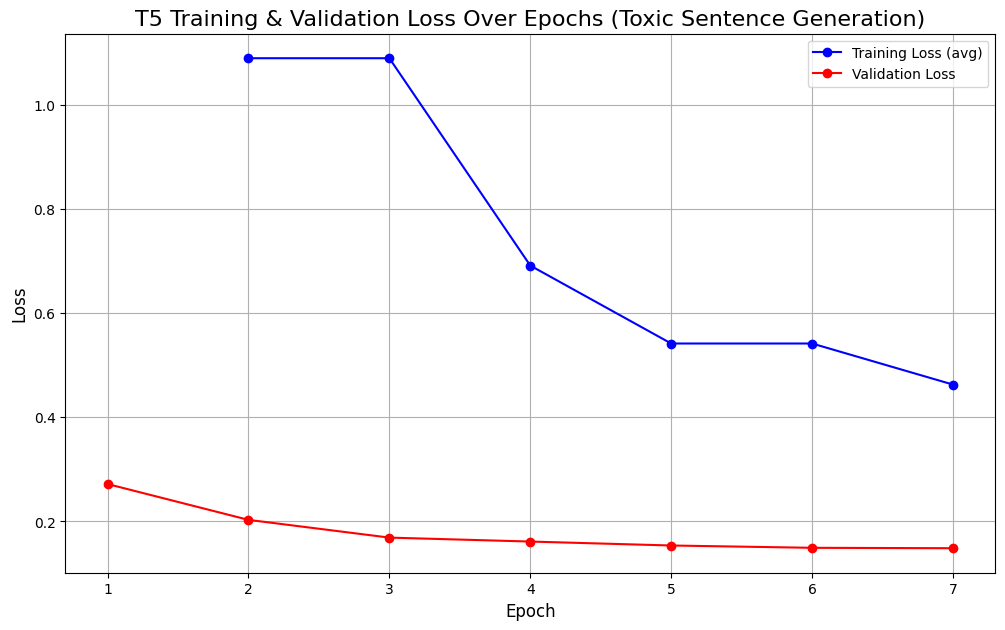


[INFO] Evaluating T5 model on test set for generation quality (BLEU & ROUGE)...


Evaluating T5 Generation:   0%|          | 0/62 [00:00<?, ?it/s]


[RESULT] Test set performance for T5 Toxic Sentence Generation:


,Metric,Average Score
0,BLEU,0.210714
1,ROUGE-1,0.361388
2,ROUGE-2,0.278836
3,ROUGE-L,0.351978



[INFO] Example generation with T5 on new data:
Input Conversation: ["Sono davvero stanco di questo, non capisco perché fai così.", "Sei egoista e non pensi mai a nessuno tranne te stesso!", "Dobbiamo trovare un compromesso, questa situazione è insostenibile."]
Conversation Category: Discussione
Generated Most Toxic Sentence (T5): 'Sono davvero stanco di questo, non capisco perché fai cos.'

[COMPLETED] T5 Fine-tuning for Most Toxic Sentence Generation completed.


In [2]:
# --- SECTION 9: T5 Fine-tuning for Most Toxic Sentence Generation ---

!pip install rouge_score

import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM, # T5 is a Seq2Seq model
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq, # Crucial for Seq2Seq padding and label handling
    EarlyStoppingCallback
)
from sklearn.model_selection import GroupShuffleSplit
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- 1. Device Configuration ---
# CORREZIONE: Rimossa la 'is' ridondante in torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

# --- 2. Load and Filter Dataset ---
dataset_path = "/kaggle/input/againunified/unified_conversation_dataset.csv"
print(f"[INFO] Loading dataset from: {dataset_path}")
try:
    df_t5_gen = pd.read_csv(dataset_path)
except FileNotFoundError:
    print(f"[ERROR] File not found: '{dataset_path}'. Please ensure it's in the correct Kaggle input directory.")
    exit()

required_cols = ['conversation', 'most_toxic_sentence', 'toxic_label', 'conversation_category']
for col in required_cols:
    if col not in df_t5_gen.columns:
        print(f"[ERROR] Required column '{col}' not found in the dataset. Available columns: {df_t5_gen.columns.tolist()}")
        exit()

df_t5_gen.dropna(subset=required_cols, inplace=True)
# Filter for conversations marked as toxic to train on relevant data
df_t5_gen = df_t5_gen[df_t5_gen["toxic_label"] == 1].reset_index(drop=True)

print(f"[INFO] Found {df_t5_gen.shape[0]} toxic conversations for T5 generation fine-tuning.")

# --- 3. Dataset Class for T5 Text Generation ---
class T5ToxicSentenceGenerationDataset(Dataset):
    def __init__(self, df, tokenizer, max_input_len=512, max_target_len=64):
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

        self.inputs = []
        self.targets = []

        # T5 uses a specific prefix to define the task.
        # Here, "extract most toxic sentence" is our task prefix.
        # Input format: "extract most toxic sentence: [conversation] category: [conversation_category]"
        # Target format: "[most_toxic_sentence]"
        for _, row in df.iterrows():
            input_text = f"extract most toxic sentence: {row['conversation']} category: {row['conversation_category']}"
            target_text = str(row['most_toxic_sentence']) # Ensure target is string

            self.inputs.append(input_text)
            self.targets.append(target_text)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_input_len,
            return_tensors='pt'
        )

        # Tokenize target. `as_target_tokenizer` ensures correct tokenization for labels.
        with self.tokenizer.as_target_tokenizer():
             target_encoding = self.tokenizer(
                target_text,
                truncation=True,
                padding='max_length',
                max_length=self.max_target_len,
                return_tensors='pt'
            )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'labels': target_encoding['input_ids'].flatten()
        }

# --- 4. Split Dataset ---
# Using GroupShuffleSplit to ensure conversations stay together in splits
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(gss.split(df_t5_gen, groups=df_t5_gen.index))

temp_df = df_t5_gen.iloc[temp_idx].reset_index(drop=True)
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df.index))

val_idx_original = temp_df.iloc[val_idx_rel].index.tolist()
test_idx_original = temp_df.iloc[test_idx_rel].index.tolist()

train_df_t5 = df_t5_gen.iloc[train_idx].reset_index(drop=True)
val_df_t5 = df_t5_gen.iloc[val_idx_original].reset_index(drop=True)
test_df_t5 = df_t5_gen.iloc[test_idx_original].reset_index(drop=True)

print(f"[INFO] Data split: {len(train_df_t5)} training samples, {len(val_df_t5)} validation samples, {len(test_df_t5)} test samples.")

# --- 5. Tokenizer and Model ---
model_name = "t5-base" # Using the base T5 model
print(f"[INFO] Loading T5 model and tokenizer: {model_name}")
tokenizer_t5 = AutoTokenizer.from_pretrained(model_name)
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

train_dataset_t5 = T5ToxicSentenceGenerationDataset(train_df_t5, tokenizer_t5)
val_dataset_t5 = T5ToxicSentenceGenerationDataset(val_df_t5, tokenizer_t5)
test_dataset_t5 = T5ToxicSentenceGenerationDataset(test_df_t5, tokenizer_t5)

collator_t5 = DataCollatorForSeq2Seq(tokenizer=tokenizer_t5, model=model_t5, padding='longest')

print(f"[INFO] T5 Datasets and DataCollator initialized. Model '{model_name}' loaded on {device}.")

# --- 6. Trainer Configuration ---
training_args_t5 = TrainingArguments(
    output_dir="./results_t5_toxic_sentence_gen", # ADAPTED output directory for T5
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=7,
    learning_rate=3e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

trainer_t5 = Trainer(
    model=model_t5,
    args=training_args_t5,
    train_dataset=train_dataset_t5,
    eval_dataset=val_dataset_t5,
    data_collator=collator_t5,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# --- 7. Train T5 Model ---
print("\n[INFO] Starting T5 fine-tuning for Most Toxic Sentence Generation...")
trainer_t5.train()
print("[INFO] T5 fine-tuning completed.")

# --- 8. Learning Curves ---
print("\n[INFO] Generating T5 learning curves...")
log_history_t5 = trainer_t5.state.log_history
train_logs_t5 = [log for log in log_history_t5 if 'loss' in log]
eval_logs_t5 = [log for log in log_history_t5 if 'eval_loss' in log]

eval_loss_t5 = [log['eval_loss'] for log in eval_logs_t5]
epochs_eval_t5 = [log['epoch'] for log in eval_logs_t5]

train_loss_df_t5 = pd.DataFrame(train_logs_t5)
avg_train_loss_t5 = []
for epoch in epochs_eval_t5:
    current_epoch_train_losses = [log['loss'] for log in train_logs_t5 if log['epoch'] <= epoch]
    if current_epoch_train_losses:
        avg_train_loss_t5.append(np.mean(current_epoch_train_losses))
    else:
        avg_train_loss_t5.append(None)

epochs_eval_filtered_t5 = [e for e, l in zip(epochs_eval_t5, avg_train_loss_t5) if l is not None]
avg_train_loss_filtered_t5 = [l for l in avg_train_loss_t5 if l is not None]

plt.figure(figsize=(12, 7))
plt.plot(epochs_eval_filtered_t5, avg_train_loss_filtered_t5, 'b-o', label='Training Loss (avg)')
plt.plot(epochs_eval_t5, eval_loss_t5, 'r-o', label='Validation Loss')
plt.title('T5 Training & Validation Loss Over Epochs (Toxic Sentence Generation)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epochs_eval_t5)
plt.show()

# --- 9. Prediction Function for T5 ---
def generate_most_toxic_sentence_t5(conversation: str, conversation_category: str, model, tokenizer, device, max_gen_len=64):
    # Input text must match the format used during training
    input_text = f"extract most toxic sentence: {conversation} category: {conversation_category}"
    
    enc = tokenizer(input_text, return_tensors='pt').to(device)
    model.eval()
    
    with torch.no_grad():
        output_tokens = model.generate(
            input_ids=enc['input_ids'], 
            attention_mask=enc['attention_mask'],
            max_new_tokens=max_gen_len,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
            temperature=1.0,
            do_sample=False
        )
        
    return tokenizer.decode(output_tokens[0], skip_special_tokens=True)

# --- 10. Evaluation on Test Set ---
print("\n[INFO] Evaluating T5 model on test set for generation quality (BLEU & ROUGE)...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1

bleu_scores_t5 = []
rouge1_scores_t5 = []
rouge2_scores_t5 = []
rougeL_scores_t5 = []

for idx, row in tqdm(test_df_t5.iterrows(), total=len(test_df_t5), desc="Evaluating T5 Generation"):
    conv = row['conversation']
    category = row['conversation_category']
    target = str(row['most_toxic_sentence']).strip()
    
    prediction = generate_most_toxic_sentence_t5(conv, category, model_t5, tokenizer_t5, device, 64) # Use max_gen_len=64 as target length

    bleu = sentence_bleu([target.split()], prediction.split(), smoothing_function=smooth)
    bleu_scores_t5.append(bleu)
    
    scores = scorer.score(target, prediction)
    rouge1_scores_t5.append(scores['rouge1'].fmeasure)
    rouge2_scores_t5.append(scores['rouge2'].fmeasure)
    rougeL_scores_t5.append(scores['rougeL'].fmeasure)

avg_bleu_t5 = sum(bleu_scores_t5) / len(bleu_scores_t5)
avg_rouge1_t5 = sum(rouge1_scores_t5) / len(rouge1_scores_t5)
avg_rouge2_t5 = sum(rouge2_scores_t5) / len(rouge2_scores_t5)
avg_rougeL_t5 = sum(rougeL_scores_t5) / len(rougeL_scores_t5)

results_df_t5 = pd.DataFrame({
    'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Average Score': [avg_bleu_t5, avg_rouge1_t5, avg_rouge2_t5, avg_rougeL_t5]
})

print("\n[RESULT] Test set performance for T5 Toxic Sentence Generation:")
display(results_df_t5)

# --- 11. Example Generation with T5 ---
print("\n[INFO] Example generation with T5 on new data:")
example_convo_t5 = '["Sono davvero stanco di questo, non capisco perché fai così.", "Sei egoista e non pensi mai a nessuno tranne te stesso!", "Dobbiamo trovare un compromesso, questa situazione è insostenibile."]'
example_category_t5 = "Discussione"

generated_toxic_sentence_t5 = generate_most_toxic_sentence_t5(
    example_convo_t5, 
    example_category_t5, 
    model_t5, tokenizer_t5, device, 64
)

print(f"Input Conversation: {example_convo_t5}")
print(f"Conversation Category: {example_category_t5}")
print(f"Generated Most Toxic Sentence (T5): '{generated_toxic_sentence_t5}'")

print("\n[COMPLETED] T5 Fine-tuning for Most Toxic Sentence Generation completed.")

2025-07-12 16:05:08.316453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752336308.517728      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752336308.573243      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[INFO] Using device: cuda
[INFO] Loading dataset from: /kaggle/input/againunified/unified_conversation_dataset.csv
[INFO] Loaded 1808 samples for RoBERTa category classification.
[INFO] Detected 18 unique conversation categories: ['Apprezzamento e Gratitudine', 'Battute Leggere e Scherzose', 'Condivisione di Hobby/Interessi', 'Controllore e Isolata', 'Dominante e Schiavo emotivo', 'Geloso-Ossessivo e Sottomessa', 'Manipolatore e Dipendente emotiva', 'Narcisista e Succube', 'Perfezionista Critico e Insicura Cronica', 'Persona violenta e Succube', 'Pianificazione Eventi Futuri', 'Psicopatico e Adulatrice', 'Risoluzione Costruttiva dei Problemi', 'Risoluzione dei Conflitti', 'Sadico-Crudele e Masochista', 'Supporto Reciproco', 'Vittimista e Croccerossina', 'Vulnerabilità Emotiva e Accettazione']
[INFO] Data split: 1446 train, 181 val, 181 test samples for RoBERTa category classification.
[INFO] Loading RoBERTa tokenizer and model: xlm-roberta-base for 18 categories.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] RoBERTa Category Datasets initialized.

[INFO] Starting XLM-RoBERTa fine-tuning for Conversation Category Classification...


/tmp/ipykernel_36/623587482.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
/tmp/ipykernel_36/623587482.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,2.701400,1.838418,0.497238,0.435745,0.446655,0.497238
2,1.732200,1.276850,0.602210,0.574032,0.638605,0.602210
3,1.210000,1.019201,0.723757,0.683286,0.663891,0.723757
4,1.030200,0.911017,0.723757,0.700941,0.706416,0.723757
5,0.895000,0.871385,0.779006,0.761225,0.756077,0.779006


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_36/623587482.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
/tmp/ipykernel_36/623587482.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to g

[INFO] XLM-RoBERTa fine-tuning for Conversation Category Classification completed.

[INFO] Evaluating XLM-RoBERTa on test set for Conversation Category Classification...


/tmp/ipykernel_36/623587482.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
/tmp/ipykernel_36/623587482.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13


--- Classification Report (XLM-RoBERTa - Conversation Category) ---
                                          precision    recall  f1-score   support

             Apprezzamento e Gratitudine       1.00      1.00      1.00        14
             Battute Leggere e Scherzose       1.00      1.00      1.00        10
         Condivisione di Hobby/Interessi       1.00      1.00      1.00        12
                   Controllore e Isolata       1.00      0.38      0.55         8
             Dominante e Schiavo emotivo       0.70      0.78      0.74         9
           Geloso-Ossessivo e Sottomessa       0.53      0.80      0.64        10
       Manipolatore e Dipendente emotiva       0.60      0.33      0.43         9
                    Narcisista e Succube       0.00      0.00      0.00         7
Perfezionista Critico e Insicura Cronica       0.60      0.43      0.50         7
              Persona violenta e Succube       0.42      0.56      0.48         9
            Pianificazione E

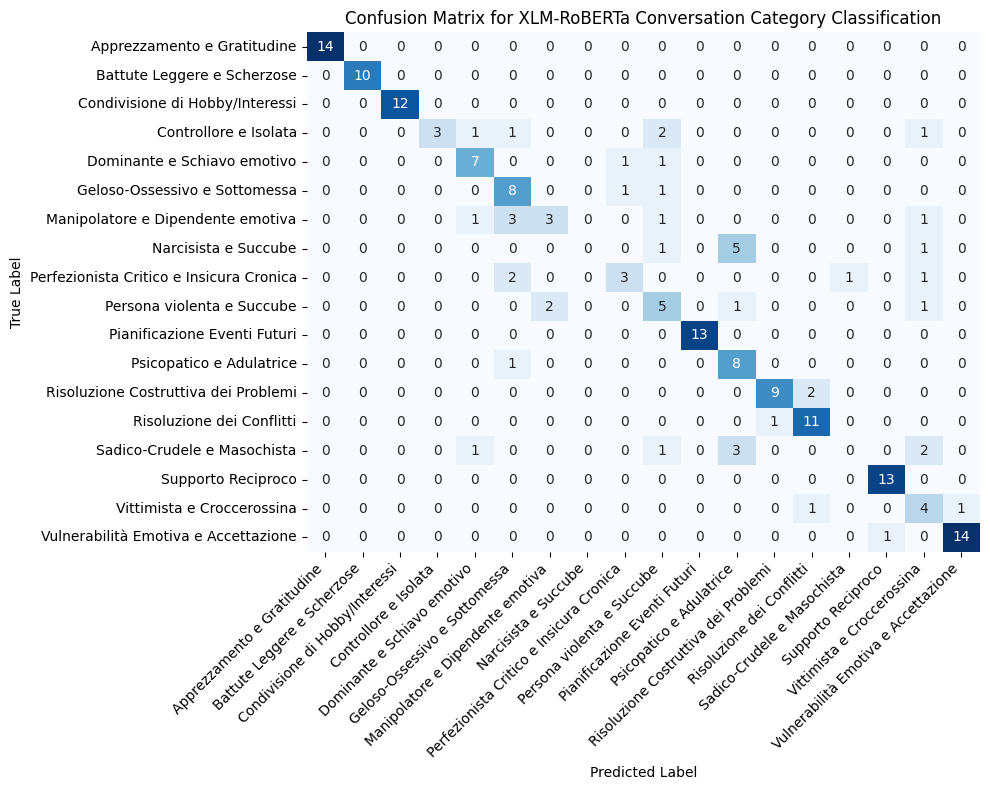


XLM-RoBERTa conversation category classification evaluation complete.
[COMPLETED] XLM-RoBERTa fine-tuning and evaluation for conversation category classification.


In [1]:
# --- SECTION: XLM-RoBERTa Fine-tuning for Conversation Category Classification (Multi-Class) ---

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification, # For classification tasks
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- 1. Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

# --- 2. Load and Prepare Dataset ---
# Adjust dataset path if needed based on your Kaggle environment
dataset_path = "/kaggle/input/againunified/unified_conversation_dataset.csv"
print(f"[INFO] Loading dataset from: {dataset_path}")
try:
    df_roberta_category = pd.read_csv(dataset_path)
except FileNotFoundError:
    # Attempt alternative path if the primary one fails, based on common Kaggle setups
    dataset_path_alt = "/kaggle/input/andanotheroneunifieddataset/unified_conversation_dataset.csv"
    print(f"[INFO] Primary dataset path not found. Trying alternative path: {dataset_path_alt}")
    try:
        df_roberta_category = pd.read_csv(dataset_path_alt)
        dataset_path = dataset_path_alt # Update path for consistency
    except FileNotFoundError:
        print(f"[ERROR] Dataset not found at either '{dataset_path}' or '{dataset_path_alt}'. Please check the path and ensure the dataset is uploaded/linked.")
        exit()

required_cols_category = ['conversation', 'conversation_category']
for col in required_cols_category:
    if col not in df_roberta_category.columns:
        print(f"[ERROR] Required column '{col}' not found in the dataset. Available columns: {df_roberta_category.columns.tolist()}")
        exit()

df_roberta_category.dropna(subset=required_cols_category, inplace=True)
print(f"[INFO] Loaded {df_roberta_category.shape[0]} samples for RoBERTa category classification.")

# --- 3. Encode Labels ---
# Convert string categories to numerical labels
label_encoder = LabelEncoder()
df_roberta_category['encoded_category'] = label_encoder.fit_transform(df_roberta_category['conversation_category'])
num_labels_category = len(label_encoder.classes_)
id_to_category = {i: category for i, category in enumerate(label_encoder.classes_)}
category_to_id = {category: i for i, category in enumerate(label_encoder.classes_)}

print(f"[INFO] Detected {num_labels_category} unique conversation categories: {label_encoder.classes_.tolist()}")

# --- 4. Dataset Class for RoBERTa Category Classification ---
class RobertaCategoryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# --- 5. Split Dataset ---
# Using stratified split for categories
train_df_roberta_category, temp_df_roberta_category = train_test_split(
    df_roberta_category, test_size=0.2, random_state=42, stratify=df_roberta_category['encoded_category']
)
val_df_roberta_category, test_df_roberta_category = train_test_split(
    temp_df_roberta_category, test_size=0.5, random_state=42, stratify=temp_df_roberta_category['encoded_category']
)

print(f"[INFO] Data split: {len(train_df_roberta_category)} train, {len(val_df_roberta_category)} val, {len(test_df_roberta_category)} test samples for RoBERTa category classification.")

# --- 6. Tokenizer and Model ---
model_name_roberta = "xlm-roberta-base" # Using XLM-RoBERTa as a reliable multilingual alternative
print(f"[INFO] Loading RoBERTa tokenizer and model: {model_name_roberta} for {num_labels_category} categories.")

try:
    tokenizer_roberta_category = AutoTokenizer.from_pretrained(model_name_roberta)
    model_roberta_category = AutoModelForSequenceClassification.from_pretrained(model_name_roberta, num_labels=num_labels_category).to(device)
except Exception as e:
    print(f"[ERROR] Failed to load RoBERTa model or tokenizer: {e}")
    print("There might be a temporary network issue or a problem with the model on Hugging Face Hub. Please try again later.")
    exit()


# Prepare encodings
train_encodings_roberta_category = tokenizer_roberta_category(
    train_df_roberta_category['conversation'].tolist(),
    truncation=True, padding=True, max_length=512, return_tensors='pt'
)
val_encodings_roberta_category = tokenizer_roberta_category(
    val_df_roberta_category['conversation'].tolist(),
    truncation=True, padding=True, max_length=512, return_tensors='pt'
)
test_encodings_roberta_category = tokenizer_roberta_category(
    test_df_roberta_category['conversation'].tolist(),
    truncation=True, padding=True, max_length=512, return_tensors='pt'
)

train_labels_roberta_category = train_df_roberta_category['encoded_category'].tolist()
val_labels_roberta_category = val_df_roberta_category['encoded_category'].tolist()
test_labels_roberta_category = test_df_roberta_category['encoded_category'].tolist()

train_dataset_roberta_category = RobertaCategoryDataset(train_encodings_roberta_category, train_labels_roberta_category)
val_dataset_roberta_category = RobertaCategoryDataset(val_encodings_roberta_category, val_labels_roberta_category)
test_dataset_roberta_category = RobertaCategoryDataset(test_encodings_roberta_category, test_labels_roberta_category)

print("[INFO] RoBERTa Category Datasets initialized.")

# --- 7. Metrics Computation for Multi-Class Classification ---
def compute_metrics_roberta_category(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    f1_weighted = f1_score(labels, preds, average='weighted')
    precision_weighted = precision_score(labels, preds, average='weighted')
    recall_weighted = recall_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

# --- 8. Trainer Configuration ---
training_args_roberta_category = TrainingArguments(
    output_dir="./results_xlm_roberta_category_classifier", # Output directory
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_xlm_roberta_category_classifier', # Log directory
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    report_to="none"
)

trainer_roberta_category = Trainer(
    model=model_roberta_category,
    args=training_args_roberta_category,
    train_dataset=train_dataset_roberta_category,
    eval_dataset=val_dataset_roberta_category,
    compute_metrics=compute_metrics_roberta_category,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# --- 9. Train RoBERTa Model for Category Classification ---
print("\n[INFO] Starting XLM-RoBERTa fine-tuning for Conversation Category Classification...")
trainer_roberta_category.train()
print("[INFO] XLM-RoBERTa fine-tuning for Conversation Category Classification completed.")

# --- 10. Evaluate on Test Set ---
print("\n[INFO] Evaluating XLM-RoBERTa on test set for Conversation Category Classification...")
predictions_roberta_category = trainer_roberta_category.predict(test_dataset_roberta_category)
y_pred_roberta_category_raw = np.argmax(predictions_roberta_category.predictions, axis=1)
y_true_roberta_category = test_labels_roberta_category

# Map predicted and true numerical labels back to original category names for the report
y_pred_roberta_category_names = label_encoder.inverse_transform(y_pred_roberta_category_raw)
y_true_roberta_category_names = label_encoder.inverse_transform(y_true_roberta_category)

print("\n--- Classification Report (XLM-RoBERTa - Conversation Category) ---")
print(classification_report(y_true_roberta_category_names, y_pred_roberta_category_names, target_names=label_encoder.classes_.tolist()))

print("\n--- Confusion Matrix (XLM-RoBERTa - Conversation Category) ---")
cm_roberta_category = confusion_matrix(y_true_roberta_category_names, y_pred_roberta_category_names, labels=label_encoder.classes_.tolist())
print(cm_roberta_category)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_roberta_category, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_.tolist(),
            yticklabels=label_encoder.classes_.tolist())
plt.title('Confusion Matrix for XLM-RoBERTa Conversation Category Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nXLM-RoBERTa conversation category classification evaluation complete.")
print("[COMPLETED] XLM-RoBERTa fine-tuning and evaluation for conversation category classification.")